In [1]:
# Make the cells wider in the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
grid_fn = "./hourly-energy-consumption/PJME_hourly.csv"
pjm_df = pd.read_csv(grid_fn, index_col=0)
pjm_df.sort_index(inplace=True)

In [3]:
# In reality, we should pick a single month and do all our simulations on that month, since the
# seasonal variation is quite obvious across the whole year.
# Just fix which data we use for train and test later, doesn't stop me from working on other stuff

one_year = 24*365
train_df = pjm_df[-2*one_year:-one_year]
assert(pd.isnull(train_df).values.sum() == 0)
train = train_df.values
test_df = pjm_df[-one_year:]
assert(pd.isnull(test_df).values.sum() == 0)
test = test_df.values

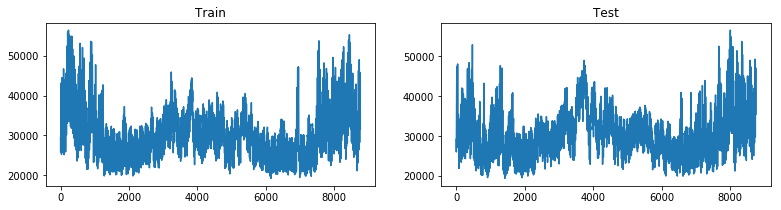

In [4]:
plt.figure(figsize=(13,3))
plt.subplot(1,2,1)
plt.plot(train)
plt.title("Train")
plt.subplot(1,2,2)
plt.plot(test)
plt.title("Test");

# Train the regression model

We're going to train a regression model which forecasts 4 hours into the future. In the beginning, we're going to use only the forecast of the next hour (easier to represent the state that way) but if we get past that, we'll try extending the time horizon. 

I tried using the Lasso version from sklearn as well, but to predict multiple steps into the future took the lasso model much longer to train (many orders of magnitude longer) so we're just going to stick with ridge

In [5]:
from sklearn.linear_model import RidgeCV
from time import time

In [6]:
# Since we're going to use cross validation, don't need to separate train and test sets
data = pjm_df.values.squeeze()
# Trim the data for quick development
# data = data[-10000:]

n_all = data.shape[0]
n_feat = 24 # using past 24 hours of data as features
n_horizon = 3 # number of steps into the future to predict
n_samps = n_all - (n_feat + n_horizon) + 1

# Create the X and y matrices
# X is shape (n_samples, n_features). Since we're using past 24 hours for forecast, n_features=24
X = np.zeros((n_samps, n_feat))
y = np.zeros((n_samps, n_horizon))
for i in range(n_samps):
    x_start = i
    x_stop = x_start + n_feat
    X[i,:] = data[x_start:x_stop]

    y_start = x_stop
    y_stop = y_start + n_horizon
    y[i,:] = data[y_start:y_stop]
    

In [7]:
tic = time()
cv_folds = 5
ridge = RidgeCV(cv=cv_folds).fit(X,y)
print("Time taken to train Ridge with %i fold CV: %.0f sec" % ( cv_folds, time() - tic))

Time taken to train Ridge with 5 fold CV: 2 sec


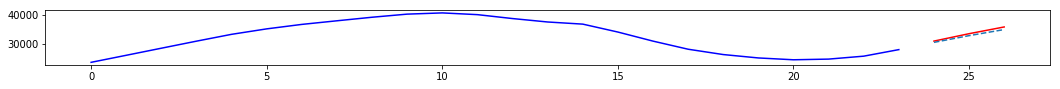

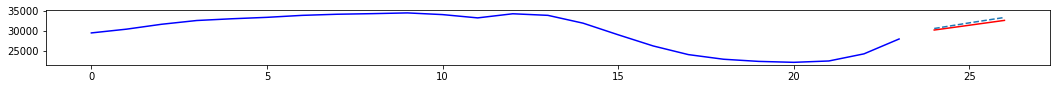

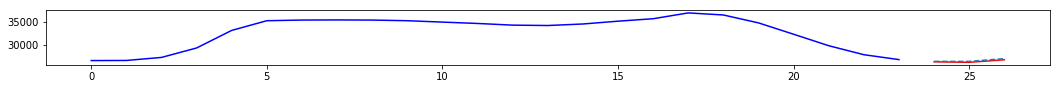

In [8]:
# Plot a few random predictions to make sure they're decent
num_plots = 3
for i in range(num_plots):
    plt.figure(figsize=(18,1))
    ind = np.random.randint(0, n_samps)
    plt.plot(range(24), X[ind,:], color='blue')
    plt.plot(range(24, 24+n_horizon), y[ind,:], color='red')
    plt.plot(range(24, 24+n_horizon), ridge.predict(X[ind,:].reshape(1,-1)).squeeze(), '--')
    

# Making a reference data object

This object will be the size of data, with an additional dimension of size 3.
The first vector will be the true grid demand
The second vector will be the peak so far for that calendar day
The third vector will be binary, and it will be 1 where ever the highest demand on that day is, 0 else where

In [9]:
trimmed_len = n_all - (n_all % 24)
ref_data = np.zeros((3, trimmed_len))
ref_data[0,:] = data[:trimmed_len]
# ref_data[0,:]: grid demand
# ref_data[1,:]: peak value in that day
# ref_data[2,:]: 1 if hour of daily peak, 0 otherwise

# Assign the peak value to each segment of 24
# Going by 24 will be slightly off because of leap years but we'll fudge it anyways
num_days = trimmed_len // 24
for day_ind in range(num_days):
    
    peak = ref_data[0, day_ind*24]
    peak_vec = np.zeros(24)
    for hour_ind in range(24):
        master_ind = 24*day_ind + hour_ind
        curr_demand = ref_data[0, master_ind]
        
        ref_data[1, master_ind] = peak
        peak_vec[hour_ind] = peak
        
        # update the peak only AFTER assigning for this interval, because
        # we want to record the peak SO FAR, so if this interval is the peak
        # then we want the demand in this interval to EXCEED our peak so far
        if curr_demand > peak: peak = curr_demand
        
        
    max_hour = np.argmax(peak_vec)
    master_peak_ind = max_hour + 24*day_ind
    ref_data[2, master_peak_ind] = 1
    

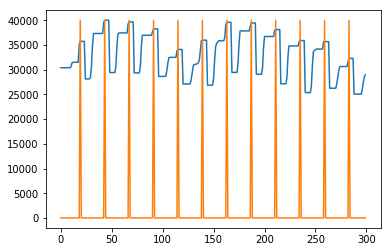

In [10]:
plt.plot(ref_data[1,:300])
plt.plot(ref_data[2,:300]*40000);

# Create the reward function

The reward function will take in a state vector and action and return the reward. For the first iteration, we're only looking at when the time horizon is 1, so we're only basing our reward off of the immediate future (myopic). In this case, we don't expect the model to learn how to hold back on discharging when the next 3 hours are all peaks, which is unideal but easier to start with.

In [11]:
def myopic_reward(s, bat, a):
    '''
    Returns reward for embedded state vector s, battery charge bat, and action a.
    Basically, first checks to make sure we're not doing an illegal charge or discharge
    Then, checks to see if next interval would be a new peak, and assigns reward according to action
    
    s is the state vector of length n_horizon which has entries 0 if not exceeding peak in that interval
    and 1 if it will exceed peak. Since this is myopic, we only consider s[0] for calculations.
    
    bat is either 0, 1, 2, representing how many hours of discharge are remaining.

    a: int in set {0, 1, 2} where 0=do nothing, 1=charge, 2=discharge
    '''
    
    assert a in [0, 1, 2], "invalid action input"
    
    # First, check to make sure we're not charging when battery is full or discharging when empty
    if (bat==0 and a==2) or (bat==2 and a==1):
        return -1e5
    
    # In the case when we shouldn't need to discharge cause demand is below peak in the next interval:
    if s[0] == 0:
        
        # Do nothing
        if a==0:
            return 0
        
        # Charge safely, get a reward (assumes we already checked for overcharging battery above)
        if a==1:
            return 100
        
        # Discharge unnecessarily, negative reward
        if a==2:
            return -100
        
    # If we're supposed to discharge cause demand exceeds peak in the next interval:
    if s[0] == 1:
        
        # Do nothing gets negative reward
        if a==0:
            return -100
        
        # Charging gets HUGE negative reward
        if a==1:
            return -1000
        
        # Discharge correctly, get reward
        if a==2:
            return 500

# Estimating T(curr_s, next_s) and O(curr_s, obs)

First, we're going to simplify the state space by only considering a time horizon of 3. Then, each element in the
state is either +1 or 0. It's +1 if the demand exceeds peak, and 0 otherwise. In our belief vector, we'll have +1 if our _forecast_ exceeds the peak and 0 otherwise.

In [13]:
num_states = 8
s_to_ind = {
    '[0 0 0]': 0,
    '[0 0 1]': 1,
    '[0 1 0]': 2,
    '[0 1 1]': 3,
    '[1 0 0]': 4,
    '[1 0 1]': 5,
    '[1 1 0]': 6,
    '[1 1 1]': 7
}
T_counts = np.zeros((8,8))
O_counts = np.zeros((8,8))

prev_state = 0

for i in range(24, trimmed_len-n_horizon):
    x = ref_data[0, i-n_feat:i]
    true_demand = ref_data[0, i:i+n_horizon]
    # Can't use the future peak values, have to assume we only have the current peak value
    peak_vals = ref_data[1, i] * np.ones(n_horizon)
    real_diffs = ((np.sign(true_demand - peak_vals) + 1) // 2).astype(np.int) # get them as 1 or 0
    
    pred = ridge.predict(x.reshape(1,-1)).squeeze()
    estimated_diffs = ((np.sign(pred - peak_vals) + 1) // 2).astype(np.int)
    
    curr_state = s_to_ind[str(real_diffs)]
    obs = s_to_ind[str(estimated_diffs)]
    
    T_counts[prev_state, curr_state] += 1
    O_counts[curr_state, obs] += 1
    
    prev_state = curr_state
    
    if i%10000==0: print("%i / %i" % (i, trimmed_len))

10000 / 145344
20000 / 145344
30000 / 145344
40000 / 145344
50000 / 145344
60000 / 145344
70000 / 145344
80000 / 145344
90000 / 145344
100000 / 145344
110000 / 145344
120000 / 145344
130000 / 145344
140000 / 145344


In [14]:
T_matrix = T_counts / T_counts.sum()
O_matrix = O_counts / O_counts.sum()
def simple_transition(prev_s, next_s):
    '''
    Returns prob of going from prev_s to next_s, estimated using MaxLikelihood on training data
    Inputs are numpy vectors which get embedded then looked up in T_matrix
    '''
    p_s = s_to_ind[str(np.array(prev_s))]
    n_s = s_to_ind[str(np.array(next_s))]
    return T_matrix[p_s, n_s]


def transition(prev_s, next_s, prev_bat, next_bat, action):
    '''
    This function is the proper version of transition which includes the battery charge
    Basically, it calls simple_transition and gives prob 0 if the difference between
    prev_batand next_bat doesn't match the action (charge, do nothing, discharge) and
    otherwise uses the value from simple transition
    '''
    prob = simple_transition(prev_s, next_s)
    
    # Cases in which action and battery charge are correct
    if (action==0 and prev_bat==next_bat) or (action==1 and prev_bat==next_bat-1) or (action==2 and prev_bat==next_bat+1):
        return prob
    else:
        return 0


def simple_observe(state, obs):
    '''
    Returns probability of observing obs when in state s
    Both are numpy vectors which get embedded then looked up in O_matrix
    '''
    s = s_to_ind[str(np.array(state))]
    o = s_to_ind[str(np.array(obs))]
    return O_matrix[s, o]

# def observe(state, obs, state_bat, obs_bat, action):
#     '''
#     Again, the proper function which tracks battery as well. Probability of observing obs and obs_bat after
#     taking action from state
#     '''
#     prob = simple_observe(state, obs)
    
#     # Cases in which action and battery charge are correct
#     if (action==0 and s_bat==next_bat) or (action==1 and prev_bat==next_bat-1) or (action==2 and prev_bat==next_bat+1):
#         return prob
#     else:
#         return 0

# Try value iteration

Use value iteration but use Q instead of U to make it easier to calculate optimal policy later

In [15]:
s_set = [np.array([0,0,0]),
         np.array([0,0,1]),
         np.array([0,1,0]),
         np.array([0,1,1]),
         np.array([1,0,0]),
         np.array([1,0,1]),
         np.array([1,1,0]),
         np.array([1,1,1]),
        ]
bat_set = [0, 1, 2]
a_set = [0, 1, 2]

In [16]:
num_iters = 50
gamma = 0.9
# Try starting with this initialization instead of 0s
Q = np.zeros((len(s_set), len(bat_set), len(a_set)))
norm_tracker = np.zeros(num_iters+1)
norm_tracker[0] = np.linalg.norm(Q)
for iter_num in range(num_iters):
    for state_ind, state in enumerate(s_set):
        for bat in bat_set:
        
            rewards_vec = np.zeros(len(a_set))
            for action_ind, action in enumerate(a_set):
                immediate_r = myopic_reward(state, bat, action)
                future_r_sum = 0
                
                for sp in s_set:
                    future_r_sum += simple_transition(state, sp) * np.max(Q[state_ind, bat, :])
                
                total_reward = immediate_r + gamma*future_r_sum
                Q[state_ind, bat, action_ind] = total_reward
                
#             U[state_ind, bat] = np.max(rewards_vec)
            
    norm_tracker[iter_num+1] = np.linalg.norm(Q)
                
            

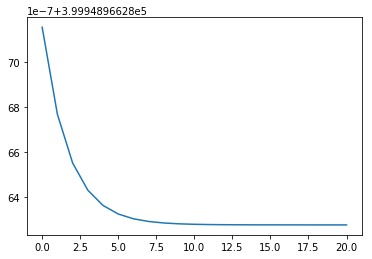

In [17]:
plt.plot(norm_tracker[30:])

# Function to evaluate performance for given Q

In [18]:
def evaluate_Q(Q, data_set):
    U = np.argmax(Q, axis=2)
            
    # Run a simulation on the given dataset using U[o, bat] to make decisions
    bat = 2
    peak_so_far = 0
    reward_history = np.zeros(data_set.shape[1] - n_horizon - 24)
    action_history = np.zeros_like(reward_history)
    peak_history = np.zeros_like(reward_history)
    counter = 0
    
    true_peaks_hit_counter = 0
    illegal_charge_counter = 0
    illegal_discharge_counter = 0
    
    
    for i in range(24, data_set.shape[1]-n_horizon):
#     for i in range(24, 24+20):
        peak_history[counter] = peak_so_far
        
        x = data_set[0, i-n_feat:i]
        pred = ridge.predict(x.reshape(1,-1)).squeeze()
        estimated_diffs = ((np.sign(pred - peak_so_far*np.ones(n_horizon)) + 1) // 2).astype(np.int)
        obs = s_to_ind[str(estimated_diffs)]
        
        true_demand = data_set[0, i:i+n_horizon]
        peak_vals = data_set[1, i:i+n_horizon]
        real_diffs = ((np.sign(true_demand - peak_vals) + 1) // 2).astype(np.int) # get them as 1 or 0
        
        action = U[obs, bat]
        action_history[counter] = action
        reward_history[counter] = myopic_reward(real_diffs, bat, action)
        
        if action==2 and data_set[2,i]==1:
            true_peaks_hit_counter += 1
        
        if action==1 and bat==2:
            illegal_charge_counter += 1
            
        if action==2 and bat==0:
            illegal_discharge_counter += 1
        
#         print("True demand: ", true_demand)
#         print("True peak vals: ", peak_vals)
#         print("peak so far: ", peak_so_far)
#         print("estimated diffs: ", estimated_diffs)
#         print("real diffs: ", real_diffs)
#         print("action: ", action)
#         print("reward: ", reward_history[counter])
        
        
        if action==1 and bat<2:
            # charged, increase bat
            bat += 1
        elif action==2 and bat>0:
            # discharged, decrease bat
            bat -= 1
            
        counter += 1
        
        # Update peak if a new one was set
        if data_set[0, i] > peak_so_far:
#             print("UPDATING PEAK")
            peak_so_far = data_set[0, i]
            
        # Reset peak if a new day starts
        if i % 24 == 0 and i>24:
#             print("RESETTING PEAK ON DAY")
            peak_so_far = data_set[0, i-1]
        
        
        if i%10000==0:
            print("%i / %i" % (i, data_set.shape[1]))
            
        
    return reward_history, action_history, peak_history, true_peaks_hit_counter, \
illegal_charge_counter, illegal_discharge_counter

In [19]:
reward_history, action_history, peaks, peaks_hit, ill_charge, ill_discharge = evaluate_Q(Q, ref_data)

10000 / 145344
20000 / 145344
30000 / 145344
40000 / 145344
50000 / 145344
60000 / 145344
70000 / 145344
80000 / 145344
90000 / 145344
100000 / 145344
110000 / 145344
120000 / 145344
130000 / 145344
140000 / 145344


In [20]:
print("Num peaks hit: %i / %i (%.2f)" % (peaks_hit, ref_data[2,:].sum(), (peaks_hit / ref_data[2,:].sum())))
print("Num illegal charges: ", ill_charge)
print("Num illegal discharge: ", ill_discharge)

Num peaks hit: 779 / 6056 (0.13)
Num illegal charges:  0
Num illegal discharge:  0


In [21]:
reward_history.sum()

4037900.0

# Try boosting reward

Estimate the probability that the current period is actually a peak period, given the observation, by counting the number of true peaks that occur per observation. Use that estimate to give extra reward when discharging for those particular observations

In [26]:
peak_in_obs_counter = np.zeros(len(s_set))

for i in range(24, ref_data.shape[1]-n_horizon):
    # Get the observation for the current index
    x = ref_data[0, i-n_feat:i]
    pred = ridge.predict(x.reshape(1,-1)).squeeze()
    estimated_diffs = ((np.sign(pred - ref_data[1,i]*np.ones(n_horizon)) + 1) // 2).astype(np.int)
    obs = s_to_ind[str(estimated_diffs)]
    
    # If this was truly a peak (i.e. if ref_data[2,i]==1) then increment the counter
    if ref_data[2,i] == 1:
        peak_in_obs_counter[obs] += 1
        
    if i%10000==0:
        print("%i / %i" % (i, ref_data.shape[1]))

10000 / 145344
20000 / 145344
30000 / 145344
40000 / 145344
50000 / 145344
60000 / 145344
70000 / 145344
80000 / 145344
90000 / 145344
100000 / 145344
110000 / 145344
120000 / 145344
130000 / 145344
140000 / 145344


In [31]:
# Check to make sure we counted a peak for every day in ref data
# except for the first day, which we skipped for convenience in prediction
assert peak_in_obs_counter.sum() == num_days-1

In [37]:
s_set

[array([0, 0, 0]),
 array([0, 0, 1]),
 array([0, 1, 0]),
 array([0, 1, 1]),
 array([1, 0, 0]),
 array([1, 0, 1]),
 array([1, 1, 0]),
 array([1, 1, 1])]

<BarContainer object of 8 artists>

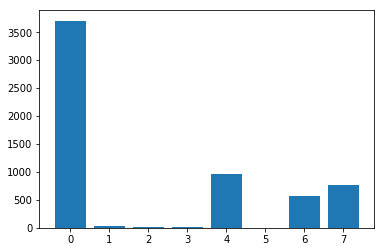

In [36]:
plt.bar(range(8),peak_in_obs_counter)

#### Comment:
It appears that a majority of the peaks occur in intervals in which our forecaster did not predict a new peak in any of the next 3 hours. This is a bummer, since it is hard to adjust our agent's behavior to improve that, since that's really a problem with the forecaster, not the model. However, this plot does show us that the cases when the forecaster yileds certain observations (namely observation 4, 6, and 7) are much more likely to actually be a peak than when we see observation 5, and we can maybe use this to improve our model by discharging less when we see observation 5 and more when we see 4, 6, or 7

In [40]:
np.argmax(Q,axis=2)

array([[1, 1, 0],
       [1, 1, 0],
       [1, 1, 0],
       [1, 1, 0],
       [0, 2, 2],
       [0, 2, 2],
       [0, 2, 2],
       [0, 2, 2]])

In [45]:
def boosted_reward(s, bat, a):
    '''
    This is a function that calls the myopic_reward function, then also adds an additional
    bonus reward if we're discharging in observations of states 4, 6, or 7
    
    s is the state vector of length n_horizon which has entries 0 if not exceeding peak in that interval
    and 1 if it will exceed peak. Since this is myopic, we only consider s[0] for calculations.
    
    bat is either 0, 1, 2, representing how many hours of discharge are remaining.

    a: int in set {0, 1, 2} where 0=do nothing, 1=charge, 2=discharge
    '''
    
    assert a in [0, 1, 2], "invalid action input"
    
    reward = myopic_reward(s, bat, a)
    s_ind = s_to_ind[str(s)]
    if s_ind in [4, 6, 7]:
        reward += 1000
    return reward

In [46]:
num_iters = 10
gamma = 0.9
# Try starting with this initialization instead of 0s
Q_boosted = np.zeros((len(s_set), len(bat_set), len(a_set)))
norm_tracker = np.zeros(num_iters+1)
norm_tracker[0] = np.linalg.norm(Q_boosted)
for iter_num in range(num_iters):
    for state_ind, state in enumerate(s_set):
        for bat in bat_set:
        
            rewards_vec = np.zeros(len(a_set))
            for action_ind, action in enumerate(a_set):
                immediate_r = boosted_reward(state, bat, action)
                future_r_sum = 0
                
                for sp in s_set:
                    future_r_sum += simple_transition(state, sp) * np.max(Q_boosted[state_ind, bat, :])
                
                total_reward = immediate_r + gamma*future_r_sum
                Q_boosted[state_ind, bat, action_ind] = total_reward
                
#             U[state_ind, bat] = np.max(rewards_vec)
            
    norm_tracker[iter_num+1] = np.linalg.norm(Q_boosted)
                
            

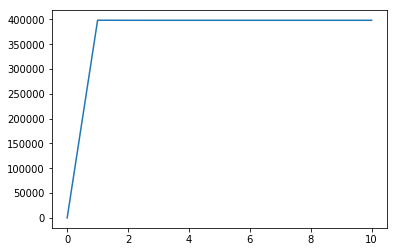

In [47]:
plt.plot(norm_tracker)

In [54]:
# Manually force the new Q to not discharge on observation 5
Q_boosted[5, :, 0] = 1e10*np.ones(3)

In [55]:
np.argmax(Q_boosted, axis=2)

array([[1, 1, 0],
       [1, 1, 0],
       [1, 1, 0],
       [1, 1, 0],
       [0, 2, 2],
       [0, 0, 0],
       [0, 2, 2],
       [0, 2, 2]])

In [56]:
reward_history, action_history, peaks, peaks_hit, ill_charge, ill_discharge = evaluate_Q(Q_boosted, ref_data)

10000 / 145344
20000 / 145344
30000 / 145344
40000 / 145344
50000 / 145344
60000 / 145344
70000 / 145344
80000 / 145344
90000 / 145344
100000 / 145344
110000 / 145344
120000 / 145344
130000 / 145344
140000 / 145344


In [57]:
print("Num peaks hit: %i / %i (%.2f)" % (peaks_hit, ref_data[2,:].sum(), (peaks_hit / ref_data[2,:].sum())))
print("Num illegal charges: ", ill_charge)
print("Num illegal discharge: ", ill_discharge)

Num peaks hit: 778 / 6056 (0.13)
Num illegal charges:  0
Num illegal discharge:  0


In [58]:
reward_history.sum()

4037500.0

In [ ]:
# Actually got worse... bummer. Oh well.